# Notebook de treinamento de redes convolucionais com os dados classificados por especialistas com segmentação completa

Neste notebook treinamos diversas arquiteturas de redes convolucionais partindo dos pesos da ImageNet. Para este notebook, usamos apenas os dados anotados por especialistas e avaliamos as redes no conjunto de validação. Utilizamos a segmentação completa.

# Base de dados e importações

In [ ]:
!gdown --id 1sy3UCtDbsAkdlCvPcUoLIsblmcHdPI8v --output dados.zip
!unzip dados.zip
!gdown --id 1wG0iOHehIWF38kEpGhuHfFRotBBMC9t_ --output CSV.zip
!unzip CSV.zip

Downloading...
From: https://drive.google.com/uc?id=1sy3UCtDbsAkdlCvPcUoLIsblmcHdPI8v
To: /content/dados.zip
33.3MB [00:00, 106MB/s] 
Archive:  dados.zip
   creating: content/audios_MEL_segmentados_concatenados_especialistas_completo/
  inflating: content/audios_MEL_segmentados_concatenados_especialistas_completo/e0107451-503c-48b0-9a9e-675a3a0c834e.jpg  
  inflating: content/audios_MEL_segmentados_concatenados_especialistas_completo/9b8791f6-9c76-41a6-b8bf-3090c8b4609f.jpg  
  inflating: content/audios_MEL_segmentados_concatenados_especialistas_completo/6d25354c-712b-4d24-831a-e99a95dd597b.jpg  
  inflating: content/audios_MEL_segmentados_concatenados_especialistas_completo/b2f44fa1-bf02-421f-afaf-9c19de73caf9.jpg  
  inflating: content/audios_MEL_segmentados_concatenados_especialistas_completo/6e3510f8-1fb9-4bd7-b316-adddd9b5fd67.jpg  
  inflating: content/audios_MEL_segmentados_concatenados_especialistas_completo/7667763a-3a74-4a29-b5f3-67b626922e05.jpg  
  inflating: content/audios

In [ ]:
import pandas as pd
from collections import Counter
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

Foi efetuado o mapeamento das classes que até então era string categórico, para os valores 0, 1 e 2.

*   healthy - 0 
*   symptomatic -  1 
*   COVID-19 - 2

In [ ]:
train = pd.read_csv('/content/CSV/train.csv')
val = pd.read_csv('/content/CSV/val.csv')
train['classInt'] = train['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
val['classInt'] = val['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
train['classStr'] = train['classInt'].astype('str')
val['classStr'] = val['classInt'].astype('str')
train['uuid'] = train['uuid'] + '.jpg'
val['uuid'] = val['uuid'] + '.jpg'

Utilizou-se os pesos para cada classe como forma de lidar com o desbalanceamento dos dados.

Ficando dessa forma:

*   healthy -  representado pelo 0 - ficou com o peso 1.3982300884955752
*   symptomatic -  represenatado pelo 1 - ficou com o peso 1.0 
*   COVID-19 - represenatado pelo 2 - ficou com o peso 1.5906040268456376

In [ ]:
# Determinando os pesos
counter = Counter(train['classInt'])  
max_val = float(max(counter.values()))  
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}    
class_weights 

{0: 1.3982300884955752, 1: 1.0, 2: 1.5906040268456376}

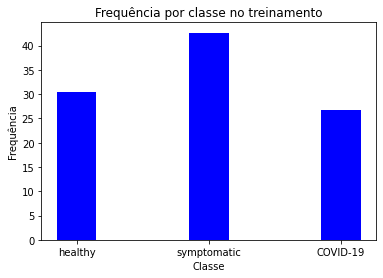

In [ ]:
plt.bar(0, len(train.values[train.classInt.values == 0])/len(train.values) * 100, width=0.3, color='blue')
plt.bar(1, len(train.values[train.classInt.values == 1])/len(train.values) * 100, width=0.3, color='blue')
plt.bar(2, len(train.values[train.classInt.values == 2])/len(train.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe no treinamento')
plt.savefig('Treinamento-especialista.png')

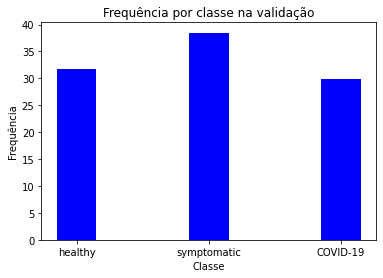

In [ ]:
plt.bar(0, len(val.values[val.classInt.values == 0])/len(val.values) * 100, width=0.3, color='blue')
plt.bar(1, len(val.values[val.classInt.values == 1])/len(val.values) * 100, width=0.3, color='blue')
plt.bar(2, len(val.values[val.classInt.values == 2])/len(val.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe na validação')
plt.savefig('Validacao.png')

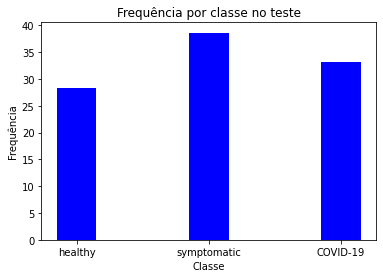

In [ ]:
teste = pd.read_csv('/content/CSV/test.csv')
teste['classInt'] = teste['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
plt.bar(0, len(teste.values[teste.classInt.values == 0])/len(teste.values) * 100, width=0.3, color='blue')
plt.bar(1, len(teste.values[teste.classInt.values == 1])/len(teste.values) * 100, width=0.3, color='blue')
plt.bar(2, len(teste.values[teste.classInt.values == 2])/len(teste.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe no teste')
plt.savefig('Teste.png')

# Função para treinamento de modelos

Como foi analisado que a execução de uma época da rede dura poucos segundos iremos testar a base com esse pré-processamento em 21 redes diferentes da imagenet para ver qual obteve a melhor acurácia tornando-a por fim o nosso baseline inicial. As redes a serem analisadas são listadas abaixo:

ResNet50
ResNet101	
ResNet152	
EfficientNetB0
EfficientNetB1
EfficientNetB2
EfficientNetB3
EfficientNetB4
EfficientNetB5	
EfficientNetB6	
EfficientNetB7	
MobileNet	
MobileNetV2	
DenseNet121	
DenseNet169	
DenseNet201	
InceptionV3	
InceptionResNetV2	
Xception	
VGG16	
VGG19	

In [ ]:
def cria_e_treina_rede(model_name, train_df, val_df, batch_size=32, callbacks=[], image_size=(256, 256), pooling='avg', loss='categorical_crossentropy', epochs=500, class_weights=class_weights, trainable=True):

  if model_name == 'resnet50' or model_name == 'resnet101' or model_name == 'resnet152':
    preprocessing_function = tf.keras.applications.resnet.preprocess_input
  elif model_name == 'efficientnetb0' or model_name == 'efficientnetb1' or model_name == 'efficientnetb2' or model_name == 'efficientnetb3' or model_name == 'efficientnetb4' or model_name == 'efficientnetb5'  or model_name == 'efficientnetb6' or model_name == 'efficientnetb7':
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
  elif model_name == 'mobilenet':
    preprocessing_function = tf.keras.applications.mobilenet.preprocess_input
  elif model_name == 'mobilenetv2':
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
  elif model_name == 'densenet121' or model_name == 'densenet169' or model_name == 'densenet201':
    preprocessing_function = tf.keras.applications.densenet.preprocess_input
  elif model_name == 'inceptionv3':
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input
  elif model_name == 'inceptionresnetv2':
    preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input
  elif model_name == 'xception':
    preprocessing_function = tf.keras.applications.xception.preprocess_input
  elif model_name == 'vgg16':
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
  elif model_name == 'vgg19':
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input

  datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocessing_function,
  )

  train_generator = datagen.flow_from_dataframe(
    train_df, directory='/content/content/audios_MEL_segmentados_concatenados_especialistas_completo', x_col='uuid', y_col='classStr',
    target_size=image_size, class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42, color_mode='rgb')

  val_generator = datagen.flow_from_dataframe(
    val_df, directory='/content/content/audios_MEL_segmentados_concatenados_especialistas_completo', x_col='uuid', y_col='classStr',
    target_size=image_size, class_mode='categorical', batch_size=batch_size, shuffle=False, seed=42, color_mode='rgb')
  
  if model_name == 'resnet50':
    pre_trained = tf.keras.applications.ResNet50(include_top=False, pooling=pooling)
  elif model_name == 'resnet101':
    pre_trained = tf.keras.applications.ResNet101(include_top=False, pooling=pooling)
  elif model_name == 'resnet152':
    pre_trained = tf.keras.applications.ResNet152(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb0':
    pre_trained = tf.keras.applications.EfficientNetB0(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb1':
    pre_trained = tf.keras.applications.EfficientNetB1(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb2':
    pre_trained = tf.keras.applications.EfficientNetB2(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb3':
    pre_trained = tf.keras.applications.EfficientNetB3(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb4':
    pre_trained = tf.keras.applications.EfficientNetB4(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb5':
    pre_trained = tf.keras.applications.EfficientNetB5(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb6':
    pre_trained = tf.keras.applications.EfficientNetB6(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb7':
    pre_trained = tf.keras.applications.EfficientNetB7(include_top=False, pooling=pooling)
  elif model_name == 'mobilenet':
    pre_trained = tf.keras.applications.MobileNet(include_top=False, pooling=pooling)
  elif model_name == 'mobilenetv2':
    pre_trained = tf.keras.applications.MobileNetV2(include_top=False, pooling=pooling)
  elif model_name == 'densenet121':
    pre_trained = tf.keras.applications.DenseNet121(include_top=False, pooling=pooling)
  elif model_name == 'densenet169':
    pre_trained = tf.keras.applications.DenseNet169(include_top=False, pooling=pooling)
  elif model_name == 'densenet201':
    pre_trained = tf.keras.applications.DenseNet201(include_top=False, pooling=pooling)
  elif model_name == 'inceptionv3':
    pre_trained = tf.keras.applications.InceptionV3(include_top=False, pooling=pooling)
  elif model_name == 'inceptionresnetv2':
    pre_trained = tf.keras.applications.InceptionResNetV2(include_top=False, pooling=pooling)
  elif model_name == 'xception':
    pre_trained = tf.keras.applications.Xception(include_top=False, pooling=pooling)
  elif model_name == 'vgg16':
    pre_trained = tf.keras.applications.VGG16(include_top=False, pooling=pooling)
  elif model_name == 'vgg19':
    pre_trained = tf.keras.applications.VGG19(include_top=False, pooling=pooling)

  for layer in pre_trained.layers:
    layer.treinable = trainable

  model = tf.keras.models.Sequential([
   pre_trained,
   tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.summary()

  optimizer = tf.keras.optimizers.Adam(0.000001)

  model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])

  list_of_callbacks = []
  if 'earlystopping' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="min", restore_best_weights=True, verbose=1))
  if 'reducelr' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, mode="min", verbose=1))
  if 'checkpoint' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ModelCheckpoint('/content/' + model_name + '.hdf5', save_best_only=True, verbose=1))

  history = model.fit(train_generator, validation_data=val_generator, batch_size=batch_size, class_weight=class_weights, callbacks=list_of_callbacks, epochs=epochs)

  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title(model_name + ' accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(model_name + ' loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  predict_val = model.predict(val_generator, verbose=1)
  y_true = []

  i = 0
  for batch, label in val_generator:
    i += batch.shape[0]
    for l in np.argmax(label, axis=1):
      y_true.append(l)
    if i == len(val_df): break

  y_true = np.array(y_true)

  print(confusion_matrix(y_true, np.argmax(predict_val, axis=1)))

  cm = confusion_matrix(y_true, np.argmax(predict_val, axis=1))
  cm = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
  balanced_acc = np.trace(cm) / 3
  print('Acuracia balanceada na validacao:', balanced_acc)

  return model

# Modelos

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
35/35 [==============================] - 28s 218ms/step - loss: 1.8172 - acc: 0.4095 - val_loss: 2.4202 - val_acc: 0.3921
Epoch 2/500
35/35 [========================

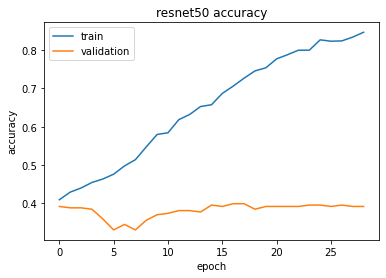

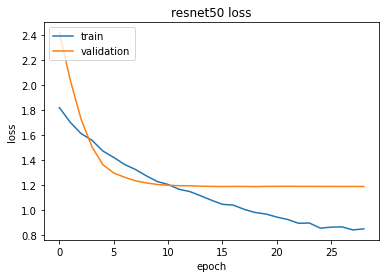

9/9 [==============================] - 2s 86ms/step
[[26 38 24]
 [34 52 21]
 [25 29 29]]
Acuracia balanceada na validacao: 0.3769444814090687


In [ ]:
cria_e_treina_rede('resnet50', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
171450368/171446536 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 2048)              42658176  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6147      
Total params: 42,664,323
Trainable params: 42,558,979
Non-trainable params: 105,344
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 19s 299ms/step - loss: 1.5500 - acc: 0.3798 - val_loss: 1.6306 - val_acc: 0.4317
Epoch 2/500
35/35 [==============================] - 9s 255ms/step - loss: 1.4802 - acc: 0.4185 - val_loss: 1.4656 - val_acc: 0.4245
Epoch 3/500
35/35 [========================

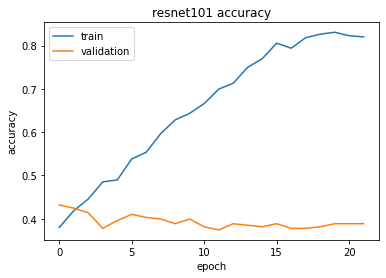

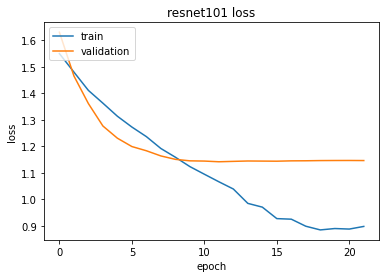

9/9 [==============================] - 2s 92ms/step
[[17 44 27]
 [28 60 19]
 [19 37 27]]
Acuracia balanceada na validacao: 0.35974356218416575


In [ ]:
cria_e_treina_rede('resnet101', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
234700800/234698864 [==============================] - 5s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 2048)              58370944  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6147      
Total params: 58,377,091
Trainable params: 58,225,667
Non-trainable params: 151,424
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 28s 423ms/step - loss: 1.5351 - acc: 0.3294 - val_loss: 1.5430 - val_acc: 0.4065
Epoch 2/500
35/35 [==============================] - 12s 353ms/step - loss: 1.4459 - acc: 0.3870 - val_loss: 1.4422 - val_acc: 0.4137
Epoch 3/500
35/35 [=======================

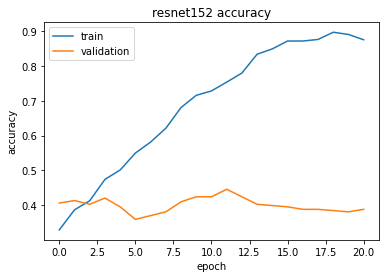

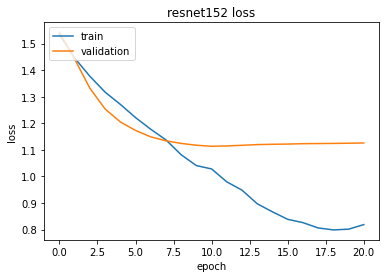

9/9 [==============================] - 3s 102ms/step
[[42 28 18]
 [33 48 26]
 [27 28 28]]
Acuracia balanceada na validacao: 0.42107341856807007


In [ ]:
cria_e_treina_rede('resnet152', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
16711680/16705208 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3843      
Total params: 4,053,414
Trainable params: 4,011,391
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 17s 276ms/step - loss: 1.4761 - acc: 0.3168 - val_loss: 1.0906 - val_acc: 0.4209
Epoch 2/500
35/35 [==============================] - 8s 218ms/step - loss: 1.4798 - acc: 0.3276 - val_loss: 1.0804 - val_acc: 0.3741
Epoch 3/500
35/35 [=============================

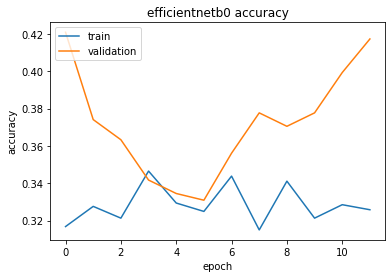

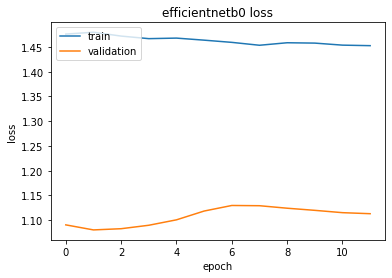

9/9 [==============================] - 2s 63ms/step
[[12 30 46]
 [23 48 36]
 [ 9 30 44]]
Acuracia balanceada na validacao: 0.3716940830441562


In [ ]:
cria_e_treina_rede('efficientnetb0', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
27025408/27018416 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 1280)              6575239   
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3843      
Total params: 6,579,082
Trainable params: 6,517,027
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 23s 361ms/step - loss: 1.4446 - acc: 0.3222 - val_loss: 1.1586 - val_acc: 0.3201
Epoch 2/500
35/35 [==============================] - 11s 308ms/step - loss: 1.4363 - acc: 0.3294 - val_loss: 1.1704 - val_acc: 0.2878
Epoch 3/500
35/35 [============================

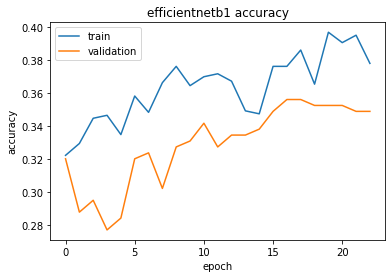

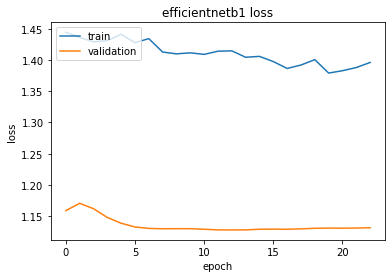

9/9 [==============================] - 2s 68ms/step
[[40 25 23]
 [41 34 32]
 [36 28 19]]
Acuracia balanceada na validacao: 0.33373937551395044


In [ ]:
cria_e_treina_rede('efficientnetb1', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
31793152/31790344 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 1408)              7768569   
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 4227      
Total params: 7,772,796
Trainable params: 7,705,221
Non-trainable params: 67,575
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 23s 379ms/step - loss: 1.4509 - acc: 0.3303 - val_loss: 1.1282 - val_acc: 0.2950
Epoch 2/500
35/35 [==============================] - 11s 312ms/step - loss: 1.4362 - acc: 0.3411 - val_loss: 1.1266 - val_acc: 0.3237
Epoch 3/500
35/35 [============================

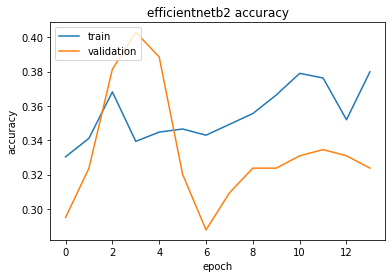

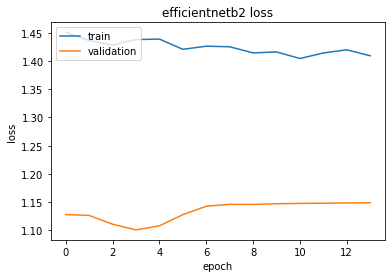

9/9 [==============================] - 2s 66ms/step
[[35 21 32]
 [33 41 33]
 [27 20 36]]
Acuracia balanceada na validacao: 0.4048799275265889


In [ ]:
cria_e_treina_rede('efficientnetb2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
43941888/43941136 [==============================] - 1s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 4611      
Total params: 10,788,146
Trainable params: 10,700,843
Non-trainable params: 87,303
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 27s 449ms/step - loss: 1.4471 - acc: 0.3312 - val_loss: 1.1138 - val_acc: 0.3237
Epoch 2/500
35/35 [==============================] - 13s 369ms/step - loss: 1.4476 - acc: 0.3474 - val_loss: 1.1162 - val_acc: 0.3129
Epoch 3/500
35/35 [==========================

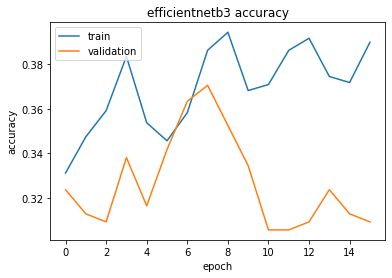

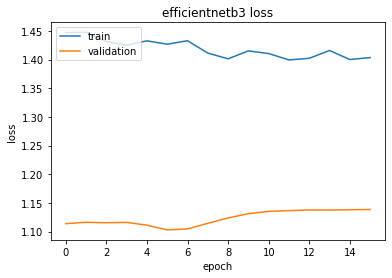

9/9 [==============================] - 2s 68ms/step
[[36 28 24]
 [33 35 39]
 [36 23 24]]
Acuracia balanceada na validacao: 0.3417834464450837


In [ ]:
cria_e_treina_rede('efficientnetb3', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
71688192/71686520 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
dense (Dense)                (None, 3)                 5379      
Total params: 17,679,202
Trainable params: 17,553,995
Non-trainable params: 125,207
_________________________________________________________________
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
35/35 [==============================] - 50s 548ms/step - loss: 1.4622 - acc: 0.3267 - val_loss: 1.1530 - val_acc: 0.2914
Epoch 2/500
35/35 [=======================

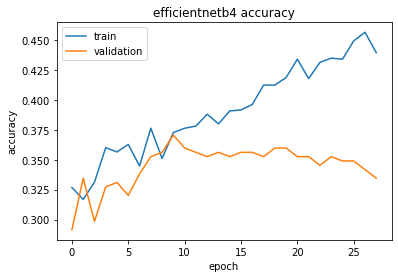

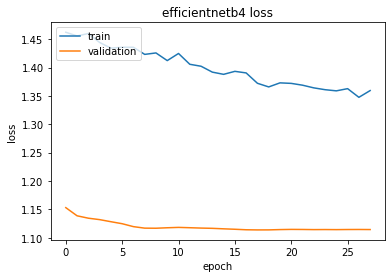

9/9 [==============================] - 3s 73ms/step
[[31 25 32]
 [30 45 32]
 [30 31 22]]
Acuracia balanceada na validacao: 0.3459645719667113


In [ ]:
cria_e_treina_rede('efficientnetb4', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
115269632/115263384 [==============================] - 2s 0us/step
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 2048)              28513527  
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 6147      
Total params: 28,519,674
Trainable params: 28,346,931
Non-trainable params: 172,743
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 45s 386ms/step - loss: 1.4451 - acc: 0.3465 - val_loss: 1.1109 - val_acc: 0.3273
Epoch 2/500
70/70 [==============================] - 24s 336ms/step - loss: 1.4432 - acc: 0.3384 - val_loss: 1.1273 - val_acc: 0.2878
Epoch 3/500
70/70 [=======================

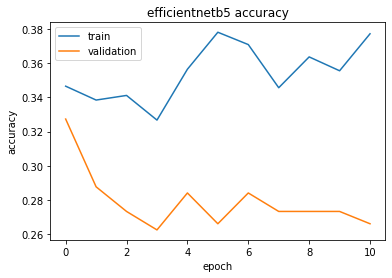

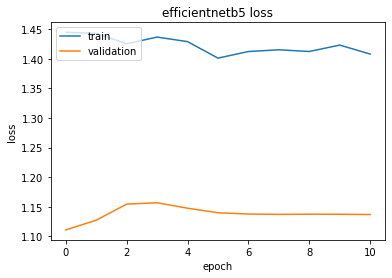

18/18 [==============================] - 3s 47ms/step
[[11 54 23]
 [25 61 21]
 [14 50 19]]
Acuracia balanceada na validacao: 0.30800304019817587


In [ ]:
cria_e_treina_rede('efficientnetb5', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
165240832/165234480 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 2304)              40960143  
_________________________________________________________________
dense (Dense)                (None, 3)                 6915      
Total params: 40,967,058
Trainable params: 40,742,619
Non-trainable params: 224,439
_________________________________________________________________
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
70/70 [==============================] - 91s 686ms/step - loss: 1.4357 - acc: 0.3384 - val_loss: 1.1259 - val_acc: 0.2878
Epoch 2/500
70/70 [=====================

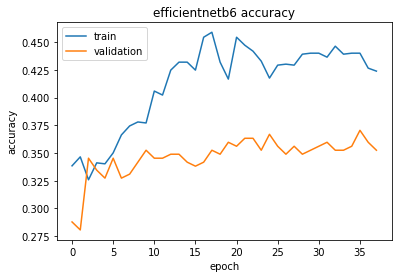

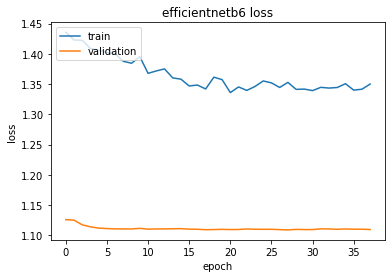

18/18 [==============================] - 6s 101ms/step
[[28 25 35]
 [31 41 35]
 [35 18 30]]
Acuracia balanceada na validacao: 0.3542683904692687


In [ ]:
cria_e_treina_rede('efficientnetb6', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
258080768/258076736 [==============================] - 6s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 2560)              64097687  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 7683      
Total params: 64,105,370
Trainable params: 63,794,643
Non-trainable params: 310,727
_________________________________________________________________
Epoch 1/500
139/139 [==============================] - 106s 520ms/step - loss: 1.4300 - acc: 0.3312 - val_loss: 1.1490 - val_acc: 0.2806
Epoch 2/500
139/139 [==============================] - 67s 479ms/step - loss: 1.4284 - acc: 0.3384 - val_loss: 1.1244 - val_acc: 0.2806
Epoch 3/500
139/139 [================

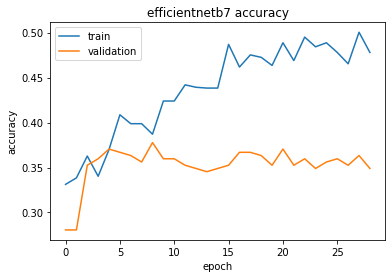

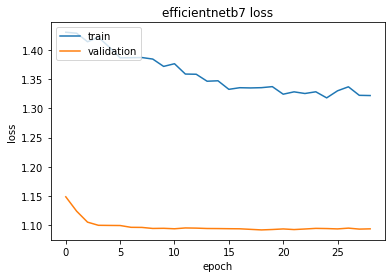

35/35 [==============================] - 7s 77ms/step
[[37 20 31]
 [38 33 36]
 [32 20 31]]
Acuracia balanceada na validacao: 0.3674532454371436


In [ ]:
cria_e_treina_rede('efficientnetb7', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=8)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
17227776/17225924 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 11s 235ms/step - loss: 1.9294 - acc: 0.3294 - val_loss: 1.8603 - val_acc: 0.3165
Epoch 2/500
35/35 [==============================] - 7s 208ms/step - loss: 1.9029 - acc: 0.3168 - val_loss: 1.7434 - val_acc: 0.3165
Epoch 3/500
35/35 [=============================

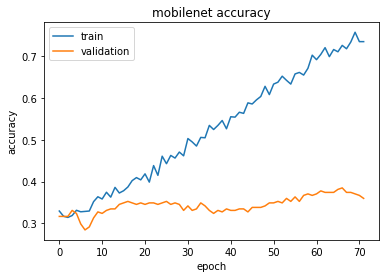

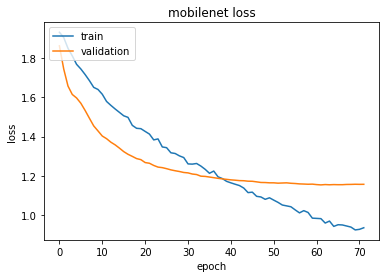

9/9 [==============================] - 1s 73ms/step
[[38 30 20]
 [40 39 28]
 [32 23 28]]
Acuracia balanceada na validacao: 0.37788452023898483


In [ ]:
cria_e_treina_rede('mobilenet', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 15s 270ms/step - loss: 2.0003 - acc: 0.4221 - val_loss: 1.7470 - val_acc: 0.3885
Epoch 2/500
35/35 [==============================] - 8s 229ms/step - loss: 1.9605 - acc: 0.4221 - val_loss: 1.7522 - val_acc: 0.3849
Epoch 3/500
35/35 [==============================]

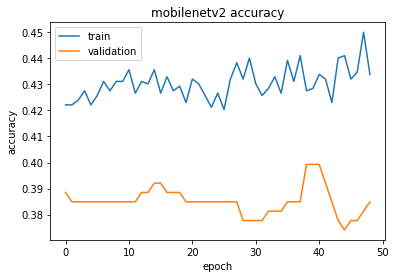

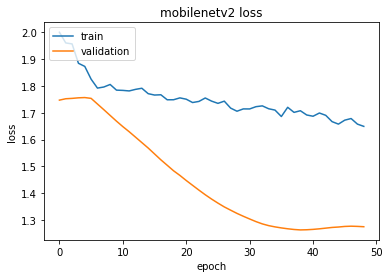

9/9 [==============================] - 1s 77ms/step
[[  5  79   4]
 [  1 103   3]
 [  4  76   3]]
Acuracia balanceada na validacao: 0.35185986085378046


In [ ]:
cria_e_treina_rede('mobilenetv2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
29089792/29084464 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 6,956,931
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 25s 374ms/step - loss: 1.7700 - acc: 0.2997 - val_loss: 1.4719 - val_acc: 0.2914
Epoch 2/500
35/35 [==============================] - 9s 269ms/step - loss: 1.6904 - acc: 0.3033 - val_loss: 1.5354 - val_acc: 0.2950
Epoch 3/500
35/35 [=============================

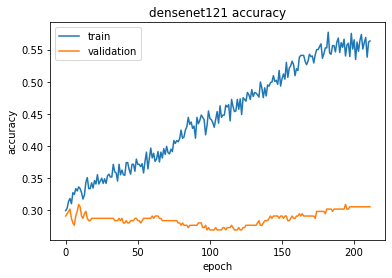

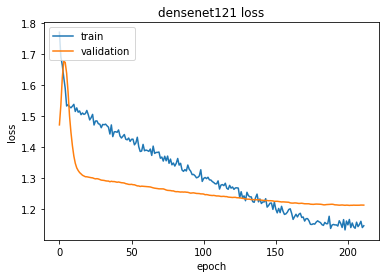

9/9 [==============================] - 3s 99ms/step
[[ 9 28 51]
 [21 33 53]
 [15 25 43]]
Acuracia balanceada na validacao: 0.3095854104608749


In [ ]:
cria_e_treina_rede('densenet121', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
51879936/51877672 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1664)              12642880  
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 4995      
Total params: 12,647,875
Trainable params: 12,489,475
Non-trainable params: 158,400
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 31s 418ms/step - loss: 1.5574 - acc: 0.3087 - val_loss: 1.2153 - val_acc: 0.3921
Epoch 2/500
35/35 [==============================] - 11s 319ms/step - loss: 1.5004 - acc: 0.3312 - val_loss: 1.1768 - val_acc: 0.3777
Epoch 3/500
35/35 [=========================

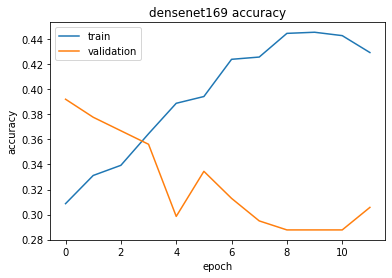

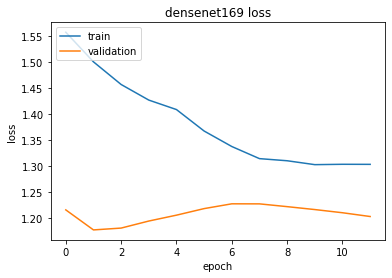

9/9 [==============================] - 3s 104ms/step
[[41 26 21]
 [56 43  8]
 [40 22 21]]
Acuracia balanceada na validacao: 0.37359676599345554


In [ ]:
cria_e_treina_rede('densenet169', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
74842112/74836368 [==============================] - 2s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 5763      
Total params: 18,327,747
Trainable params: 18,098,691
Non-trainable params: 229,056
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 44s 315ms/step - loss: 1.6358 - acc: 0.3105 - val_loss: 1.3198 - val_acc: 0.3201
Epoch 2/500
70/70 [==============================] - 17s 238ms/step - loss: 1.5751 - acc: 0.3177 - val_loss: 1.2373 - val_acc: 0.3022
Epoch 3/500
70/70 [=========================

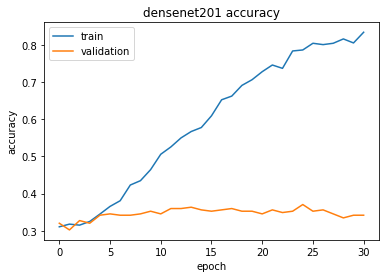

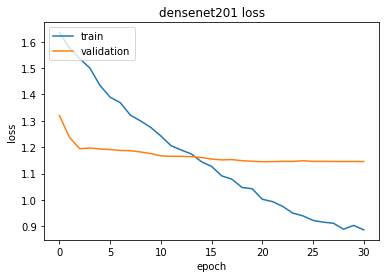

18/18 [==============================] - 4s 70ms/step
[[40 20 28]
 [48 29 30]
 [34 22 27]]
Acuracia balanceada na validacao: 0.3502915655826364


In [ ]:
cria_e_treina_rede('densenet201', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
87916544/87910968 [==============================] - 2s 0us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 21,774,499
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 19s 161ms/step - loss: 1.4904 - acc: 0.3069 - val_loss: 1.1563 - val_acc: 0.3094
Epoch 2/500
70/70 [==============================] - 9s 127ms/step - loss: 1.4662 - acc: 0.3213 - val_loss: 1.1446 - val_acc: 0.3597
Epoch 3/500
70/70 [===========================

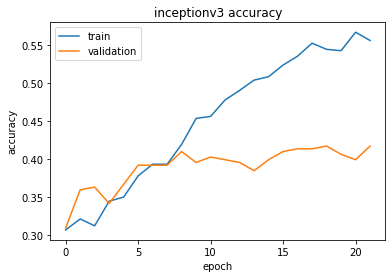

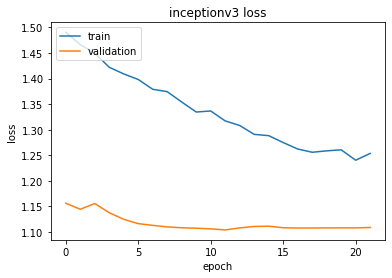

18/18 [==============================] - 2s 45ms/step
[[14 34 40]
 [26 46 35]
 [11 21 51]]
Acuracia balanceada na validacao: 0.40115176082409504


In [ ]:
cria_e_treina_rede('inceptionv3', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
219062272/219055592 [==============================] - 4s 0us/step
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 4611      
Total params: 54,341,347
Trainable params: 54,280,803
Non-trainable params: 60,544
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 41s 587ms/step - loss: 1.5617 - acc: 0.2718 - val_loss: 1.3272 - val_acc: 0.3058
Epoch 2/500
35/35 [==============================] - 16s 452ms/step - loss: 1.5378 - acc: 0.2754 - val_loss: 1.2806 - val_acc: 0.2986
Epoch 3/500
35/35 [========================

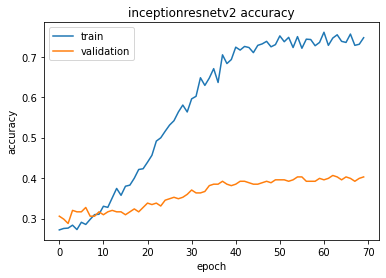

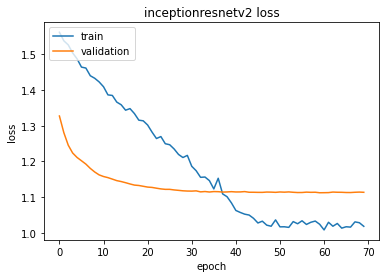

9/9 [==============================] - 4s 122ms/step
[[25 31 32]
 [26 44 37]
 [19 22 42]]
Acuracia balanceada na validacao: 0.4004433195824931


In [ ]:
cria_e_treina_rede('inceptionresnetv2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
83689472/83683744 [==============================] - 2s 0us/step
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 20,813,099
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 26s 579ms/step - loss: 1.4332 - acc: 0.3330 - val_loss: 1.1668 - val_acc: 0.2950
Epoch 2/500
35/35 [==============================] - 18s 524ms/step - loss: 1.4234 - acc: 0.3303 - val_loss: 1.1626 - val_acc: 0.2734
Epoch 3/500
35/35 [==========================

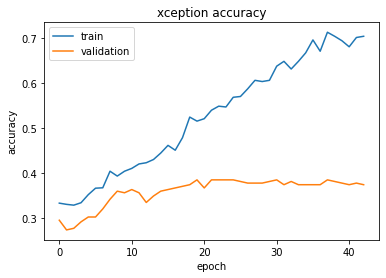

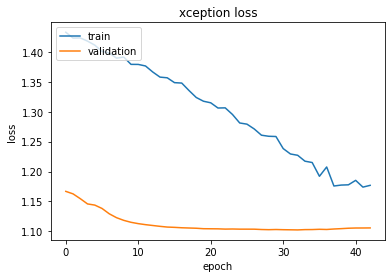

9/9 [==============================] - 2s 94ms/step
[[19 32 37]
 [20 51 36]
 [17 30 36]]
Acuracia balanceada na validacao: 0.3754265148956062


In [ ]:
cria_e_treina_rede('xception', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 14,716,227
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 16s 185ms/step - loss: 2.2988 - acc: 0.3447 - val_loss: 1.3313 - val_acc: 0.3849
Epoch 2/500
70/70 [==============================] - 11s 151ms/step - loss: 1.6860 - acc: 0.3618 - val_loss: 1.2158 - val_acc: 0.3957
Epoch 3/500
70/70 [==============================

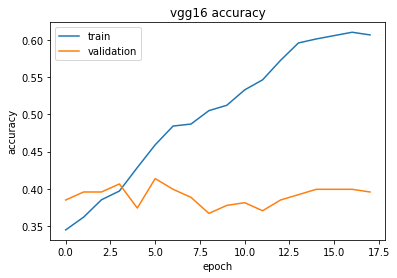

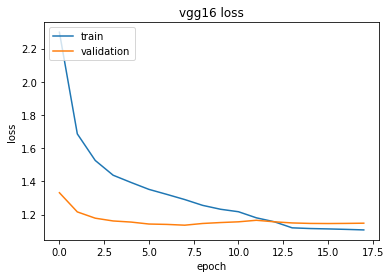

18/18 [==============================] - 1s 44ms/step
[[23 29 36]
 [33 47 27]
 [22 23 38]]
Acuracia balanceada na validacao: 0.38614909937114644


In [ ]:
cria_e_treina_rede('vgg16', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
80142336/80134624 [==============================] - 2s 0us/step
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 1539      
Total params: 20,025,923
Trainable params: 20,025,923
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 14s 179ms/step - loss: 2.0803 - acc: 0.3564 - val_loss: 1.3385 - val_acc: 0.4065
Epoch 2/500
70/70 [==============================] - 12s 175ms/step - loss: 1.5853 - acc: 0.3951 - val_loss: 1.2837 - val_acc: 0.3777
Epoch 3/500
70/70 [==============================

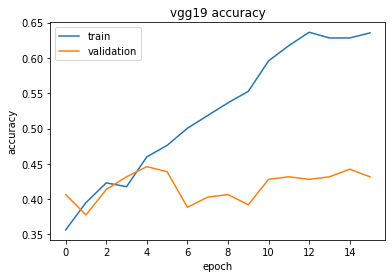

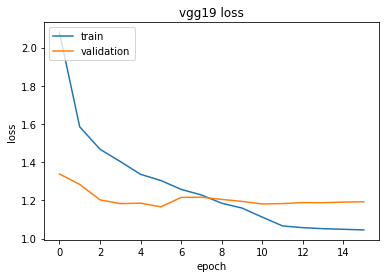

18/18 [==============================] - 1s 46ms/step
[[32 32 24]
 [23 61 23]
 [22 32 29]]
Acuracia balanceada na validacao: 0.4277091373139115


In [ ]:
cria_e_treina_rede('vgg19', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)